In [1]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
# plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs

In [2]:
pipeline_params = util.hydra_to_dict(config.pipeline)
debugging = pipeline_params['debugging']
if debugging:
    pipeline_dir = f'{config.machine.pipeline_dir}_dev'
else:
    pipeline_dir = config.machine.pipeline_dir

In [3]:
# open pickled lens list
pickles = glob(os.path.join(pipeline_dir, '01', '01_hlwas_sim_detectable_lenses_sca*.pkl'))
scas = [int(f.split('_')[-1].split('.')[0][3:]) for f in pickles]
scas = sorted([str(sca).zfill(2) for sca in scas])
sca_dict = {}
total = 0
for sca in scas:
    pickle_path = os.path.join(pipeline_dir, '01', f'01_hlwas_sim_detectable_lenses_sca{sca}.pkl')
    lens_list = util.unpickle(pickle_path)
    sca_dict[sca] = lens_list
    total += len(lens_list)
count = total
path = os.path.join(pipeline_dir, '01')
assert total != 0, f'No pickled lenses found. Check {path}.'

In [4]:
array_list = []
for sca, lens_list in sca_dict.items():
    print(f'SCA {sca}: {len(lens_list)} lenses')

    array_list.append(len(lens_list) * np.ones((100, 100)))

SCA 01: 575 lenses
SCA 02: 587 lenses
SCA 03: 566 lenses
SCA 04: 560 lenses
SCA 05: 595 lenses
SCA 06: 541 lenses
SCA 07: 559 lenses
SCA 08: 595 lenses
SCA 09: 565 lenses
SCA 10: 602 lenses
SCA 11: 561 lenses
SCA 12: 558 lenses
SCA 13: 594 lenses
SCA 14: 594 lenses
SCA 15: 590 lenses
SCA 16: 567 lenses
SCA 17: 584 lenses
SCA 18: 550 lenses


In [5]:
count_dict = {}
detectable = []
characterizable = []

for sca, lens_list in sca_dict.items():
    detectable.append(len(lens_list))
    characterizable.append(len([l for l in lens_list if l.snr > 25]))

count_dict['Detectable'] = detectable
count_dict['Characterizable'] = characterizable

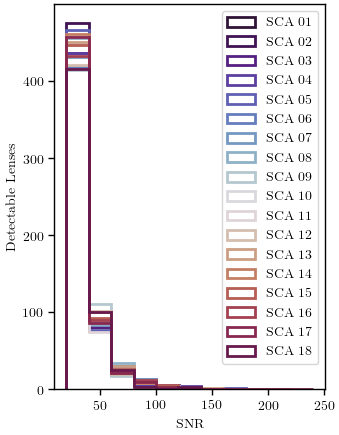

In [6]:
f, ax = plt.subplots(figsize=(3.5, 5))

binwidth = 20

cmap = plt.get_cmap('twilight_shifted')
colors = cmap(np.linspace(0, 1, 20))
ax.set_prop_cycle(color=colors)

for sca, lens_list in sca_dict.items():
    snr_list = [l.snr for l in lens_list if np.isfinite(l.snr)]
    ax.hist(snr_list, histtype='step', label=f'SCA {sca}', bins=np.arange(min(snr_list), max(snr_list) + binwidth, binwidth), lw=2.)

plt.xlabel('SNR')
plt.ylabel('Detectable Lenses')
plt.legend()
plt.savefig(os.path.join(figure_dir, 'detectable_by_sca_1.png'))
plt.show()

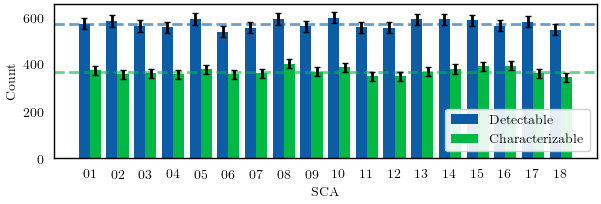

In [7]:
f, ax = plt.subplots(figsize=(7, 2))

x = np.arange(1, len(scas) + 1)
width = 0.4
multiplier = 0

ax.axhline(np.mean(count_dict['Detectable']), linestyle='--', color='C0', alpha=0.6)
ax.axhline(np.mean(count_dict['Characterizable']), linestyle='--', color='C1', alpha=0.6)

for type, count in count_dict.items():
    offset = width * multiplier
    cont = ax.bar(x + offset, count, width, label=type, yerr=np.sqrt(count), capsize=2.5)
    multiplier += 1

# for _, cap, _ in cont.errorbar.lines:
#     cap._marker._captyle = 'round'

ax.xaxis.set_ticks_position('none')
ax.set_xticks(x + (width / 2), scas)
ax.yaxis.set_ticks_position('none')
ax.set_ylabel('Count')
ax.set_xlabel('SCA')
ax.legend(loc='lower right', framealpha=0.9)

plt.savefig(os.path.join(figure_dir, 'detectable_by_sca_2.png'))
plt.show()